In [1]:
import threadpoolctl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

高消费者：我们为那些重视福利而不是费用的人提供带有旅行奖励的高级卡。
注重成本： 我们为那些避免利息费用的人开发了零费用选项。
基于风险： 我们根据客户风险状况调整了信用额度和利率。
保留： 我们通过分析消费模式和付款历史来识别有风险的客户。

In [2]:
np.random.seed(42)

In [3]:
df = pd.read_csv("k-meansjulei.csv")
df.shape 


(99, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    99 non-null     int64  
 1   Monthly_Spending       99 non-null     float64
 2   Subscription_Duration  99 non-null     int64  
 3   Usage_Rate             99 non-null     float64
 4   Support_Tickets        99 non-null     int64  
 5   Cancelled              99 non-null     int64  
dtypes: float64(2), int64(4)
memory usage: 4.8 KB


In [5]:
df.sample(10)

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
62,38,739.488554,15,0.547594,3,0
40,24,218.509402,1,0.422976,1,0
95,53,999.943535,23,0.865750,5,1
18,28,172.894435,3,0.110168,1,0
97,61,911.086341,22,0.848029,2,1
84,56,918.826143,21,0.879309,2,1
64,46,710.590063,16,0.602564,1,1
42,31,106.254563,5,0.227201,1,0
10,32,588.077553,16,0.691481,0,1
0,48,529.152948,13,0.524262,2,1


我们需要历史数据。我们了解每个客户的特征以及他们是否取消订阅.

确定取消订阅的客户与未取消订阅的客户相比的特征？
营销团队是否可以利用一些模式来制定保留策略？
对于那些没有取消的人，有什么方法可以提高他们的忠诚度吗？
是否有共同特征允许我们根据相似性对客户进行分组？

In [6]:
print(df.isnull().sum())

Age                      0
Monthly_Spending         0
Subscription_Duration    0
Usage_Rate               0
Support_Tickets          0
Cancelled                0
dtype: int64


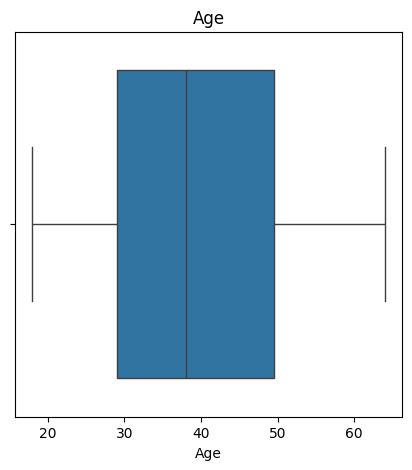

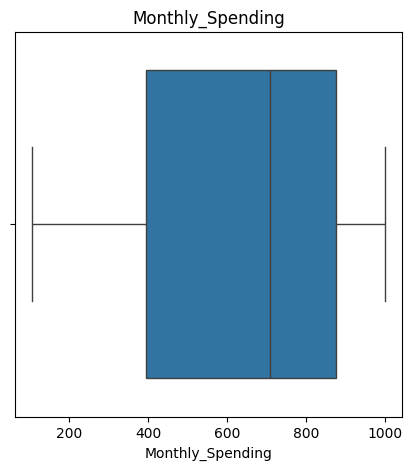

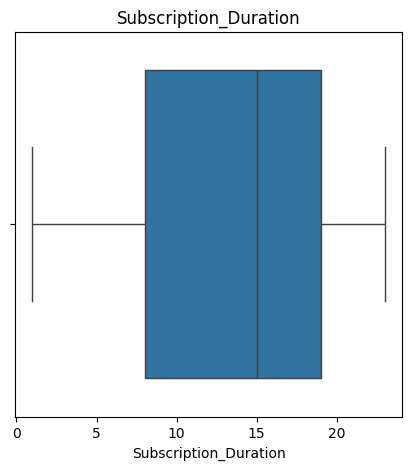

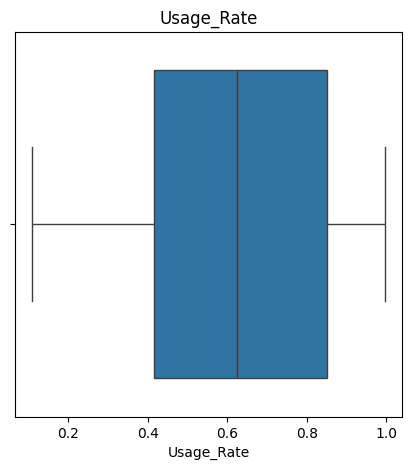

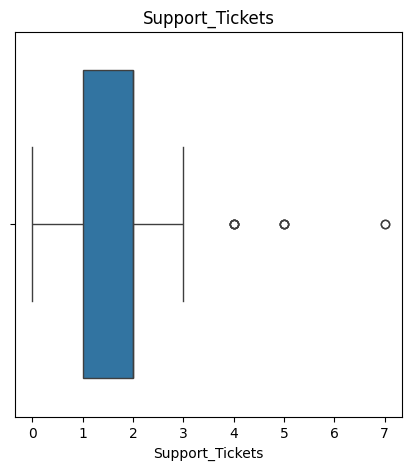

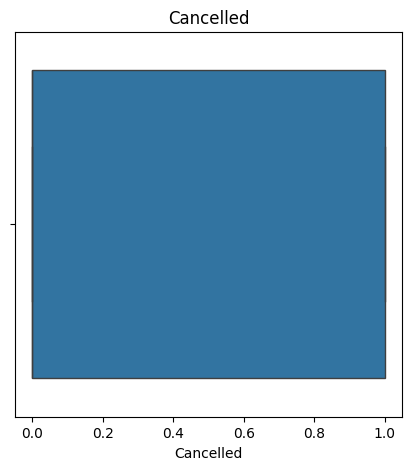

In [7]:
#异常值 创建循环来遍历数据集中的列，每个列生成一个箱线图
for column in df.columns:
    if df[column].dtype in ['int64','float64']:
        plt.figure(figsize=(5,5)) 
        sns.boxplot(x=df[column]) 
        plt.title(column) 
        plt.show()

In [8]:
#cancelled 有异常，数值表示的分类变量
df['Cancelled'].value_counts()

Cancelled
0    50
1    49
Name: count, dtype: int64

异常值对 K-Means 的影响
K-Means 算法（我们将在本项目中使用的算法）可能会受到异常值的影响，因为它依赖于数学距离计算来查找组。

异常值会扭曲此数学距离，由于这些异常值，这可能会影响算法的性能。

In [9]:
#使用 Describe 进行统计分析 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,99.0,39.888889,13.089869,18.000000,29.000000,38.000000,49.500000,64.000000
Monthly_Spending,99.0,639.071009,270.618268,106.254563,394.918421,709.104722,875.735422,999.943535
Subscription_Duration,99.0,13.646465,6.599804,1.000000,8.000000,15.000000,19.000000,23.000000
Usage_Rate,99.0,0.604374,0.263824,0.110168,0.414928,0.623406,0.849839,0.996007
Support_Tickets,99.0,1.747475,1.486974,0.000000,1.000000,2.000000,2.000000,7.000000
Cancelled,99.0,0.494949,0.502519,0.000000,0.000000,0.000000,1.000000,1.000000


In [10]:
#quantile函数计算四分位范围确定一个四分位数和第三个四分位数
Q1 = df.quantile(0.25) 
Q3 = df.quantile(0.75) 
IQR = Q3 - Q1 
print(IQR)

Age                       20.500000
Monthly_Spending         480.817001
Subscription_Duration     11.000000
Usage_Rate                 0.434911
Support_Tickets            1.000000
Cancelled                  1.000000
dtype: float64


In [11]:
#允许我们应用统计分析中广泛使用的规则，这有助于我们识别异常值。规则如下：

# 如果某个值（在任何列中）小于 Q1–2.5 倍 IQR，或大于 Q3 + 2.5 倍 IQR，则被视为异常值.
outliers = ((df < (Q1 - 2.5 * IQR)) | (df > (Q3 + 2.5 * IQR))).any(axis=1)

In [12]:
#筛选器直接应用与DataFrame 提取异常值
df_outliers = df[outliers] 
df_outliers

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
12,46,743.034018,16,0.697133,5,0
53,48,550.847824,12,0.619646,7,1
54,43,667.040379,13,0.630056,5,0
63,34,694.989179,17,0.536049,7,1
95,53,999.943535,23,0.865750,5,1
96,48,999.327367,21,0.926680,5,1


保留异常值并考虑不同的方法
现在，我将保留数据集中的异常值。 对于如何处理异常值，没有一个单一、明确、通用的定义。有些人认为最好保留异常值并应用转换;其他人则喜欢删除它们以避免影响分析，尤其是在数据分配方面。

模型评估的实用方法
做出此决定的一种有效方法是创建不同的模型：一个包含原始数据，另一个不包含异常值。然后，评估每个 API 的性能。这正是我们很快要做的事情。

相关分析
在继续之前，让我们使用 corr 方法计算相关性。


In [13]:
correlation_matrix = df.corr()

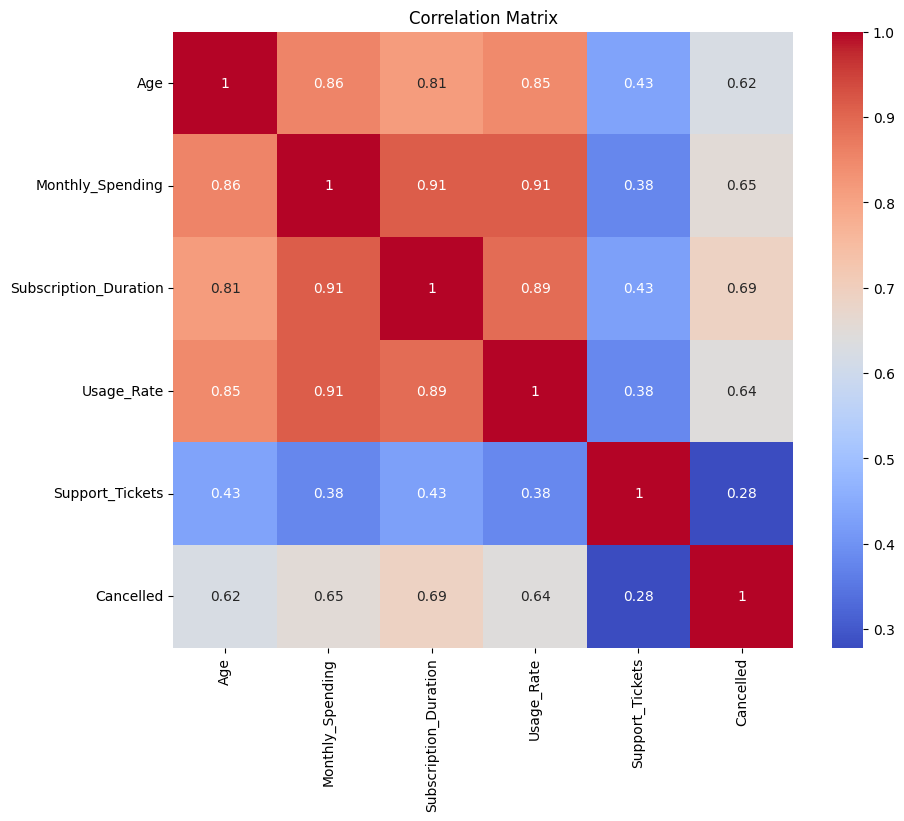

In [14]:
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()

使用 K-Means 时有两个关键点:

多重共线性：如果存在高度相关的变量，这可能会影响结果。
变量尺度：K-Means 期望所有变量都处于相同的尺度上。

标准化和降维
好消息是，通过标准化数据，您通常可以解决或至少缓解多重共线性问题。通过解决一个问题，您最终可能会解决另一个问题。

此外，相关性分析可以是降维技术的初步步骤，例如 PCA（主成分分析），我们将在项目后面应用。

PCA 是数学中一种强大的技术（杰作），用于降低维度并创建更清晰的线段可视化。

数据标准化
下一步是标准化数据，将它们置于相同的尺度上。这在使用 Machine Learning 时非常常见，尤其是在使用依赖于数学距离计算的算法（如 K-Means 算法）时。

In [15]:
scaler = StandardScaler() 
df_scaled = pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
df_scaled.head()

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
0,0.622801,-0.408241,-0.098451,-0.305201,0.170689,1.010153
1,-0.221820,0.168733,-0.098451,0.091893,0.170689,-0.989949
2,-0.682522,0.586616,0.510712,0.389261,-0.505240,-0.989949
3,-0.759306,-0.360433,-0.250741,-0.331122,0.846619,-0.989949
4,0.315666,0.061014,0.206131,0.648375,0.846619,-0.989949


定义集群数
现在，我们需要做出决定。K-Means 是一种聚类算法，它根据我们拥有的数据来识别组（集群）。

问题是：我必须将我的客户群分为多少个组？
想一想。我们只能有一个组吗？是的，但这意味着所有客户都是一样的，这没有意义。我们可以有两个组吗？三、四、五，甚至十？理想的数字是多少？

K-Means 在定义集群中的作用
K-Means 是一种无监督学习算法（我不知道解决方案或组数），这意味着它将为我们确定理想的组数。

然而，该算法并不是完全自动的 — 我们需要通过测试组数的不同值（“理想 K”）来给它一点“推动”。换句话说，我们需要对 K=3、K=4、K=5 等进行实验，然后分析结果以确定最佳聚类数。

在 K-Means 中定义 K 的值
这里一个非常相关的问题是：“算法能告诉我理想的数字是什么吗？
是的，该算法将帮助您找到理想的数字，但您需要指定要测试的选项。这是关键点。

选择要测试的适当范围
现在您可能会问：“如果我想从 1 到 100 进行测试怎么办？从技术上讲，您可以，但请考虑以下问题：拥有 10 个或更多区段真的有意义吗？

在实践中，将客户划分为 10 个或更多组对营销团队来说不是很有用。通常，理想的范围是使用 3 到 8 组之间的内容。少于 3 个可能不够，超过 8 个可能会使活动复杂化。

这个想法是，对于每个组，营销团队都可以创建有针对性的活动。为 100 个组创建 100 个营销活动没有意义。

求 K 理想值的方法
确定 K 的理想值主要有两种方法:

弯头法：评估集群内误差开始减少不太显著的点。
Silhouette Method：评估形成的集群的质量。
让我们从弯头法开始.

实现 Elbow 方法

In [16]:
#创建一个列表计算k中的每个值的sse评分误差总和
#此计算有助于我们确定添加更多聚类会产生减少误差的递减收益的点，这意味着它有助于我们找到理想的 K.
sse = [] 
k_range = range(1,11) 
for k in k_range:
    kmeans = KMeans(n_clusters=k) 
    kmeans.fit(df_scaled) 
    sse.append(kmeans.inertia_)


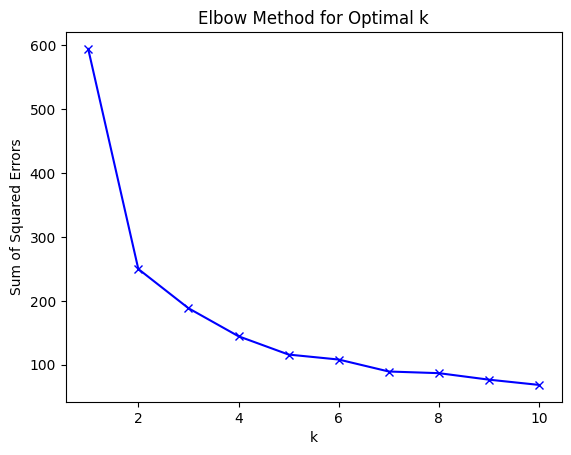

In [17]:
plt.plot(k_range, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Errors')
plt.title('Elbow Method for Optimal k')
plt.show()

选择 K 的商业决策
尽管弯头方法建议 K=4，但您可以选择测试 K=3 或 K=5，具体取决于业务环境。最终决定不是二元的，可能涉及根据项目需求进行调整。

为了加强我们的决定，让我们使用 silhouette 方法，看看它是否确认 K=4 或暗示不同的东西。测试多个方法始终是一种很好的做法。

我们可以使用 K=2 吗？是的。我们可以使用 K=3 或 K=4 吗？是的。但是你怎么知道理想的值呢？答案很简单：你不会绝对确定地知道。所有这些都是一个近似值 — 您永远不知道客户群或任何其他分组的确切数量。

您注意到该技术本身并不困难;事实上，这很简单。我们所做的是创建具有多个 K 值的 K-Means 模型，存储结果，然后在图表中可视化所有内容以做出最佳决策。

客户细分中的近似值
我们在这里所做的是尝试根据相似性对客户进行分组，因为我们知道这是一个近似值。每个客户都是独一无二的，但通过创建组或细分，我们试图找到类似的模式。因此，我们必须应对不确定性，并寻求最接近理想的解决方案。

例如，在解释肘部图时，通常将曲线开始“弯曲”的点视为 K 的理想值。在这种情况下，我将根据肘部方法考虑 K=4，然后检查轮廓法的建议

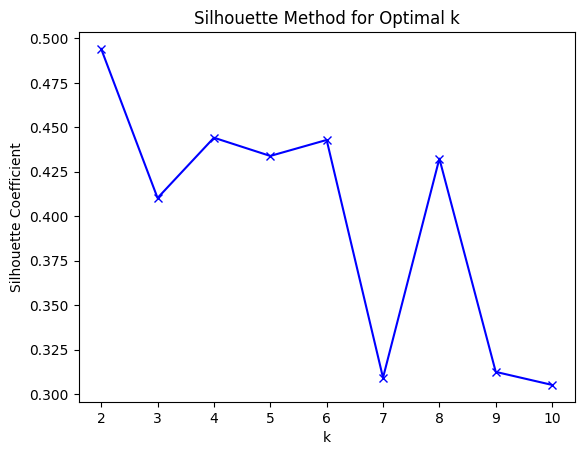

In [18]:
sil_score = [] 
for k in k_range:
    kmeans = KMeans(n_clusters=k) 
    kmeans.fit(df_scaled) 
    if k != 1:
        sil_score.append(silhouette_score(df_scaled,kmeans.labels_)) 

plt.plot(k_range[1:], sil_score, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Method for Optimal k')
plt.show()

现在，需要以不同的方式解释该图。在肘部法中，我计算误差减少以获得更好的结果，而在轮廓法中，系数越高，结果越好（接近 1 的值是理想的）。

请注意，根据 silhouette 方法，K=8、K=9 和 K=10 将是糟糕的选择。这似乎与 elbow 方法相矛盾，这就是机器学习中不确定性的本质.

正如我们已经讨论过的，与这么多团体合作是不切实际的。silhouette 方法表明 K=2 的系数最高。

In [19]:
#构建第一个集群版本，设置random_state=42
model_kmeans = KMeans(n_clusters=4,random_state=42) 
df['cluster'] = model_kmeans.fit_predict(df_scaled) 
df.sample(10)

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled,cluster
83,55,830.083378,19,0.956731,1,1,1
40,24,218.509402,1,0.422976,1,0,0
31,27,308.333704,7,0.164489,2,0,0
60,35,653.402720,15,0.514315,2,0,3
86,60,993.982880,19,0.972473,2,1,1
29,29,230.616308,2,0.130792,0,0,0
42,31,106.254563,5,0.227201,1,0,0
92,52,811.275099,19,0.891827,1,1,1
90,52,882.963900,20,0.898423,1,1,1
61,32,650.454888,16,0.669811,2,1,2


In [21]:
df_cleaned = df

In [20]:
df.shape

(99, 7)

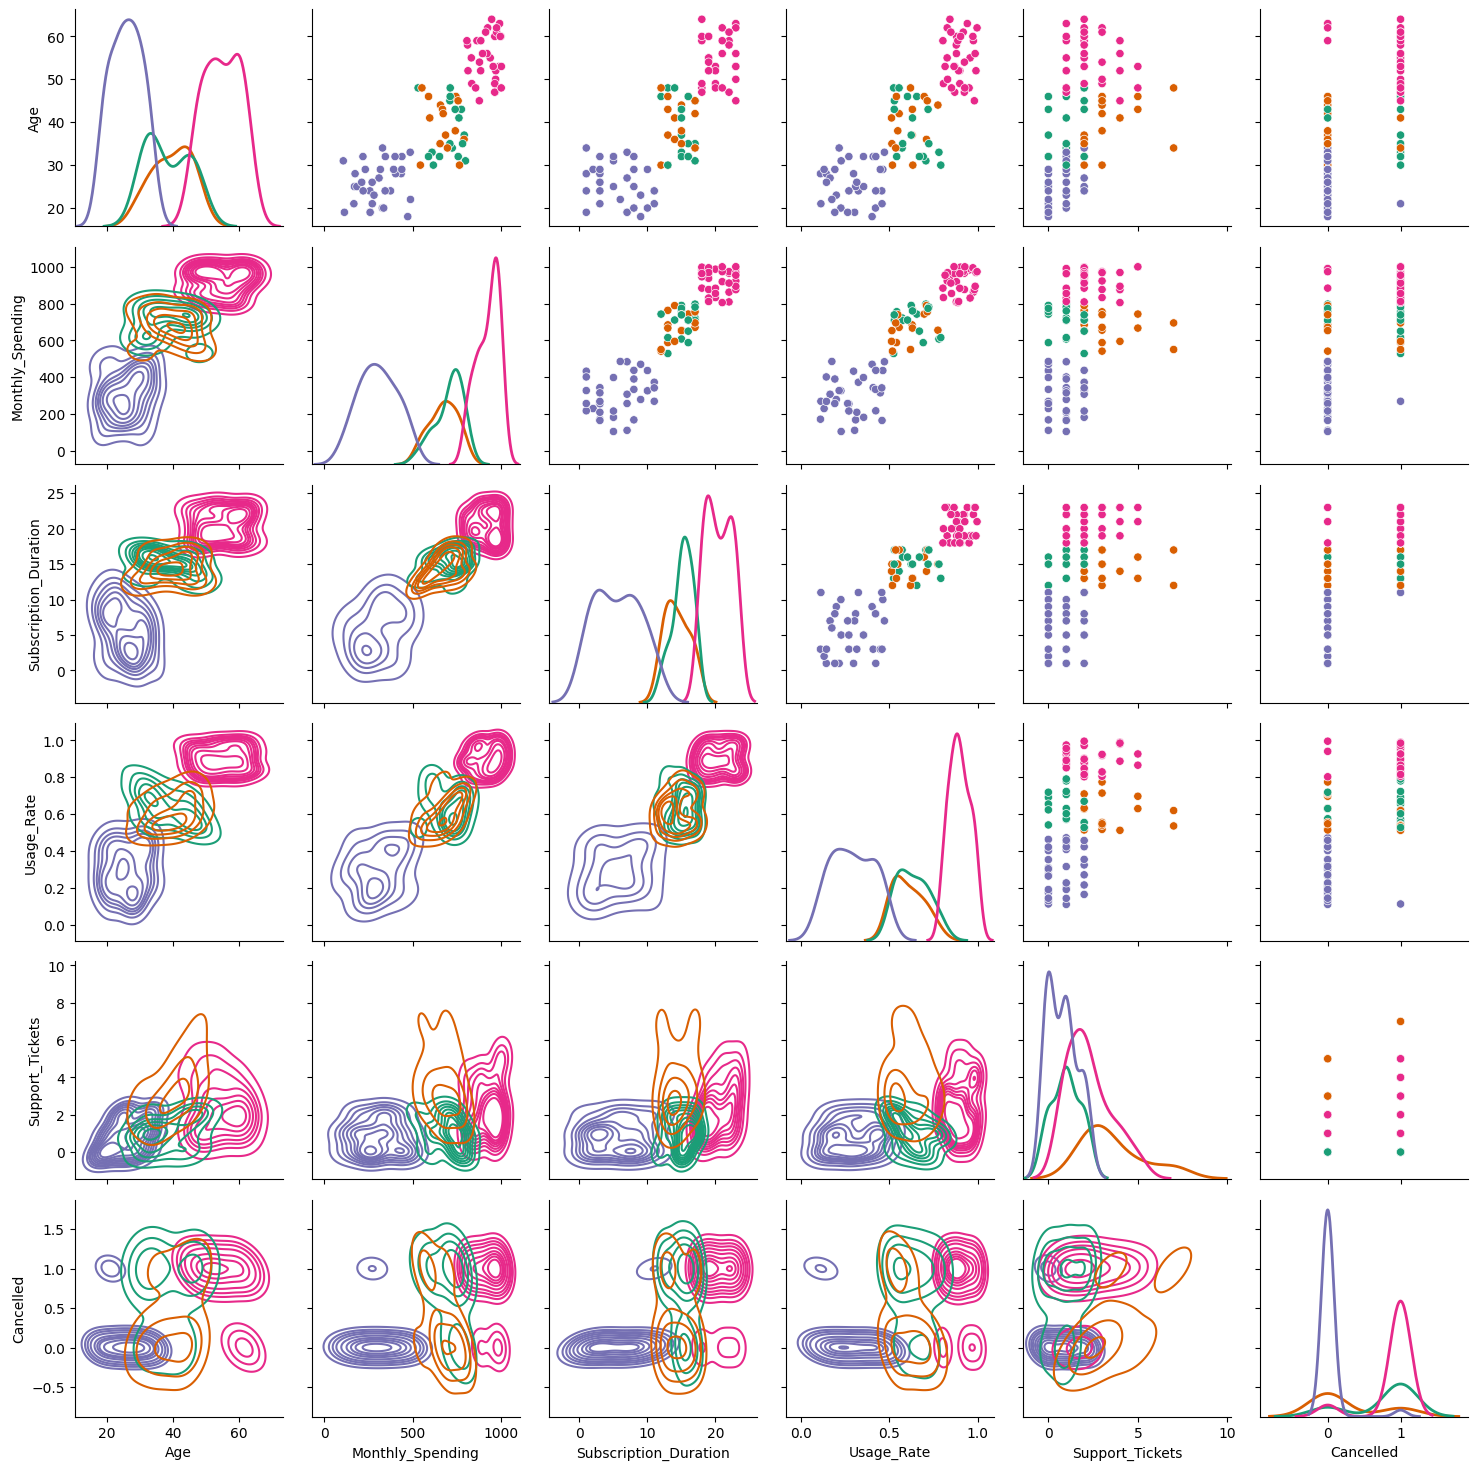

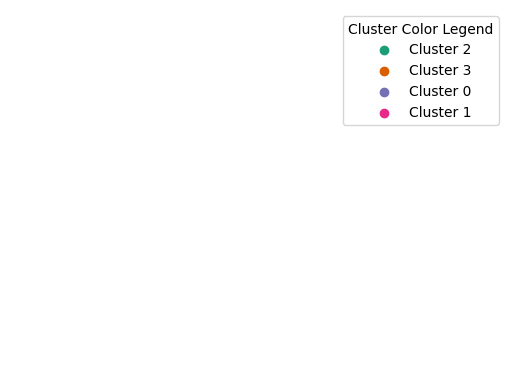

In [24]:
#seaborn创建一个pairgrid
palette = sns.color_palette('Dark2',n_colors=len(df_cleaned['cluster'].unique())) 
color_map = dict(zip(df_cleaned['cluster'].unique(),palette)) 
g = sns.PairGrid(df_cleaned,hue='cluster',palette=color_map,diag_sharey=False) 
g.map_upper(sns.scatterplot) 
g.map_lower(sns.kdeplot) 
g.map_diag(sns.kdeplot,lw=2) 
plt.show() 

for cluster, color in color_map.items():
    plt.scatter([], [], c=[color], label=f'Cluster {cluster}')
plt.legend(title='Cluster Color Legend')
plt.axis('off')
plt.show()

In [25]:
#构建第 2 个集群版本 
#删除异常值后，我们将删除clusters列
model_kmeans = KMeans(n_clusters=3,random_state=42) 
df.drop('cluster',axis=1,inplace=True) 
df.head()

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
0,48,529.152948,13,0.524262,2,1
1,37,684.502168,13,0.628494,2,0
2,31,797.016155,17,0.706550,1,0
3,30,542.025205,12,0.517458,3,0
4,44,655.498896,15,0.774564,3,0


In [26]:
df['cluster'] = model_kmeans.fit_predict(df_scaled) 
df.sample(10)

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled,cluster
82,60,997.455226,18,0.902798,2,1,1
85,54,876.178171,19,0.924417,3,1,1
67,60,962.759004,19,0.880697,1,1,1
43,26,269.360592,3,0.144021,0,0,0
6,34,722.230585,17,0.571936,1,1,2
87,52,968.423785,19,0.989904,4,1,1
89,56,893.738632,23,0.985318,4,1,1
19,28,402.144564,1,0.143157,1,0,0
78,58,809.043734,22,0.878449,2,1,1
65,43,738.737801,15,0.527540,2,1,2


In [27]:
df_cleaned = df[~outliers]

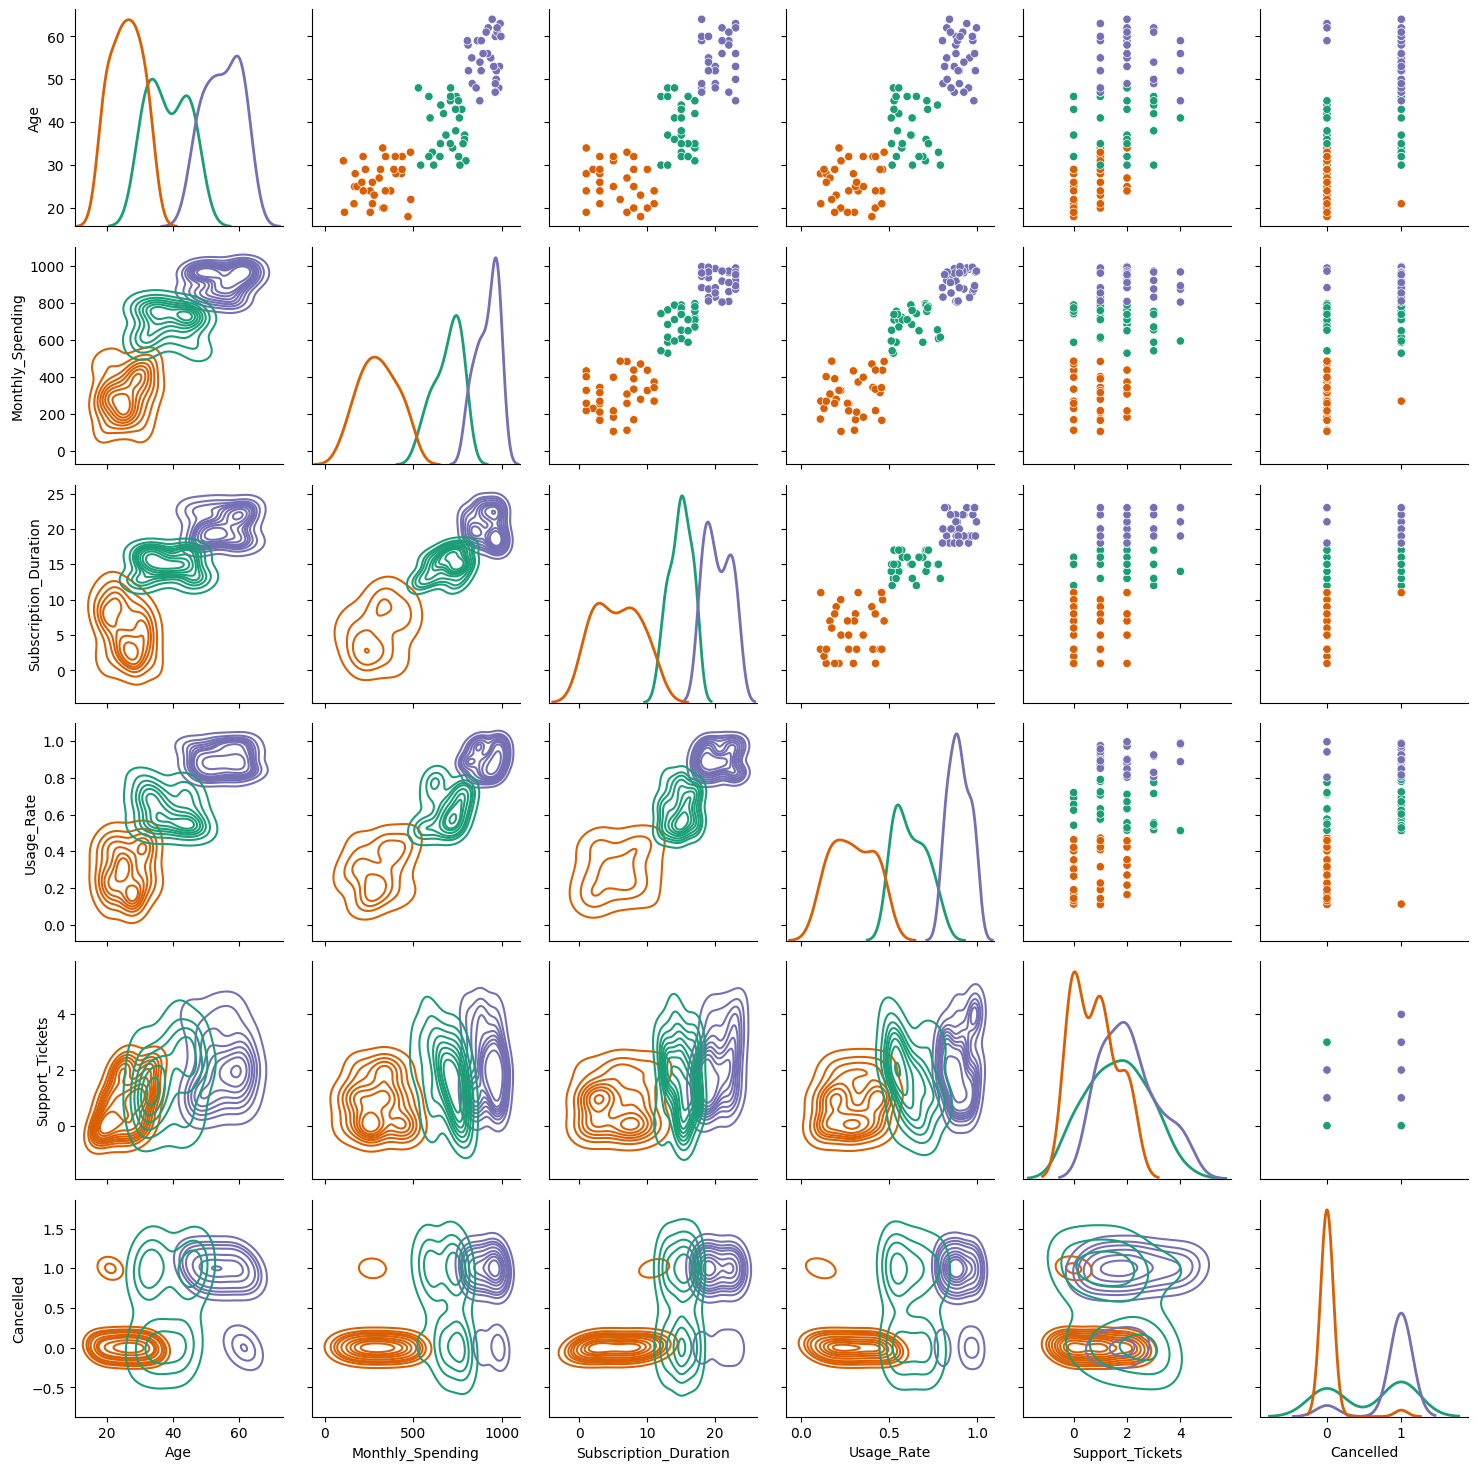

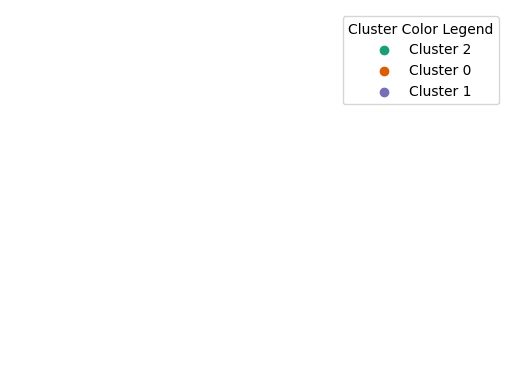

In [28]:
palette = sns.color_palette('Dark2', n_colors=len(df_cleaned['cluster'].unique()))
color_map = dict(zip(df_cleaned['cluster'].unique(), palette))

# 40. Plotting the grid chart with clusters and showing the color map
g = sns.PairGrid(df_cleaned, hue='cluster', palette=color_map, diag_sharey=False)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
plt.show()

# 41. Displaying the color map
for cluster, color in color_map.items():
    plt.scatter([], [], c=[color], label=f'Cluster {cluster}')
plt.legend(title='Cluster Color Legend')
plt.axis('off')
plt.show()

In [29]:
#分析所选模型的分类 
df_cleaned.head(5)

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled,cluster
0,48,529.152948,13,0.524262,2,1,2
1,37,684.502168,13,0.628494,2,0,2
2,31,797.016155,17,0.706550,1,0,2
3,30,542.025205,12,0.517458,3,0,2
4,44,655.498896,15,0.774564,3,0,2


In [30]:
for cluster_num in range(3):
    print(f"\n--- Cluster {cluster_num}---") 
    cluster_data = df_cleaned[df_cleaned['cluster'] == cluster_num] 

    # Display the first records
    print("First Records:")
    print(cluster_data.head())
    
    # Display the mean values
    print("\nMean Values:")
    print(cluster_data.mean())


--- Cluster 0---
First Records:
    Age  Monthly_Spending  Subscription_Duration  Usage_Rate  Support_Tickets  \
13   24        373.305408                     11    0.324511                2   
14   32        343.998663                      3    0.408387                1   
15   28        433.277965                      1    0.297518                0   
16   25        169.345861                      8    0.309093                0   
17   24        256.424243                      3    0.271016                0   

    Cancelled  cluster  
13          0        0  
14          0        0  
15          0        0  
16          0        0  
17          0        0  

Mean Values:
Age                       25.848485
Monthly_Spending         302.863443
Subscription_Duration      5.606061
Usage_Rate                 0.293108
Support_Tickets            0.787879
Cancelled                  0.030303
cluster                    0.000000
dtype: float64

--- Cluster 1---
First Records:
    Age  Monthly

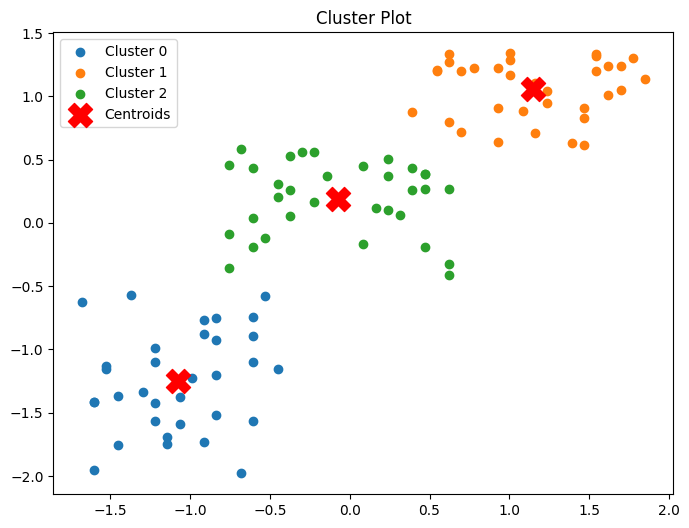

In [31]:
# Extract the centroids
centroids = model_kmeans.cluster_centers_

# Create the figure
plt.figure(figsize=(8, 6))

# Loop through clusters
for cluster_num in range(3):
    mask = df['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label=f'Cluster {cluster_num}')

# Plot the centroids
plt.scatter(model_kmeans.cluster_centers_[:, 0], 
            model_kmeans.cluster_centers_[:, 1], 
            s=300, 
            c='red', 
            marker='X', 
            label='Centroids')

plt.legend()
plt.title("Cluster Plot")
plt.show()

这是通过数学距离计算完成的，特别是欧几里得距离。换句话说，从每个点到组质心的数学距离。如果距离较小，则点将保持在该组中。如果与其他质心的距离较大，则该点将保留在该组中。就这么简单。

每个机器学习算法都是这样工作的，通过某种数学计算来找到数据模式，并提供能够进行预测、生成文本等的模型。那么现在，让我们解释这些质心.

In [32]:
centroids = model_kmeans.cluster_centers_
print(centroids)

[[-1.07807472 -1.24869086 -1.22447918 -1.1858289  -0.64861907 -0.92934034]
 [ 1.14865372  1.05786786  1.04142262  1.11634458  0.35503359  0.82832509]
 [-0.07057899  0.19082299  0.18305656  0.06948432  0.29358547  0.10101525]]


集群 0（第一行）主要包含组中未取消订阅的客户。对于大多数维度，这些值为负值且低于 -1。

集群 1（第二行）主要包含取消订阅的组中的客户。对于大多数维度，这些值为正且大于 1。

分类 2（第三行）主要包含来自两个组的客户，即取消的客户和未取消的客户。请注意，这些值接近 0，这表明此群集可能位于数据集平均值附近。

因此，现在，营销部门可以单独与这些组中的每一个合作。

In [33]:
df['cluster'].value_counts()#集群的记录总数

cluster
2    33
0    33
1    33
Name: count, dtype: int64

In [34]:
df.groupby('cluster').mean()#平均值

,Age,Monthly_Spending,Subscription_Duration,Usage_Rate,Support_Tickets,Cancelled
cluster,,,,,,
0,25.848485,302.863443,5.606061,0.293108,0.787879,0.030303
1,54.848485,923.899857,20.484848,0.897401,2.272727,0.909091
2,38.969697,690.449726,14.848485,0.622612,2.181818,0.545455


In [35]:
#计算剪影分数
score = silhouette_score(df_scaled, df['cluster'])
print(score)

0.41846445080765354


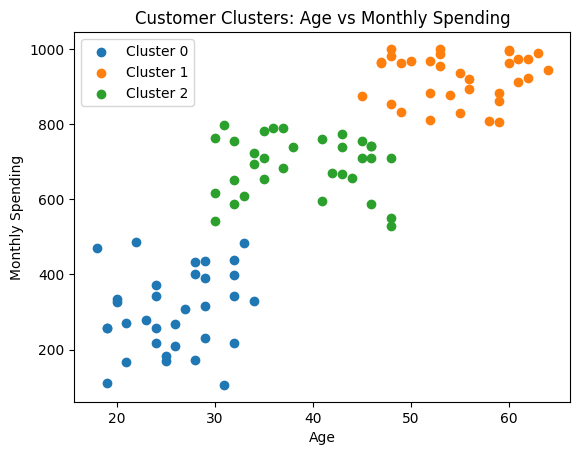

In [36]:
import matplotlib.pyplot as plt

# Plot
plt.scatter(df[df['cluster'] == 0]['Age'], df[df['cluster'] == 0]['Monthly_Spending'], label='Cluster 0')
plt.scatter(df[df['cluster'] == 1]['Age'], df[df['cluster'] == 1]['Monthly_Spending'], label='Cluster 1')
plt.scatter(df[df['cluster'] == 2]['Age'], df[df['cluster'] == 2]['Monthly_Spending'], label='Cluster 2')

# Adding title and labels
plt.title('Customer Clusters: Age vs Monthly Spending')
plt.xlabel('Age')
plt.ylabel('Monthly Spending')
plt.legend()

# Displaying the plot
plt.show()

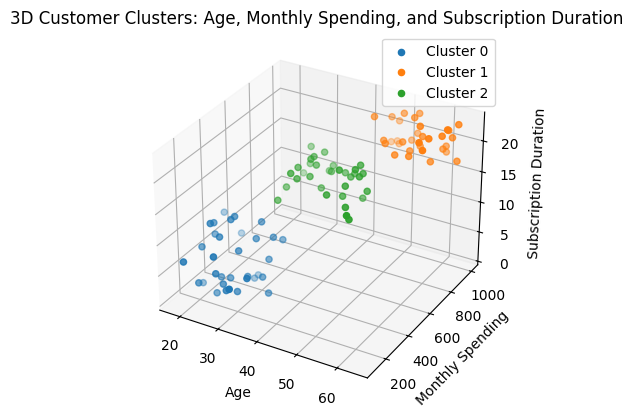

In [37]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot
ax.scatter(df[df['cluster'] == 0]['Age'], df[df['cluster'] == 0]['Monthly_Spending'], df[df['cluster'] == 0]['Subscription_Duration'], label='Cluster 0')
ax.scatter(df[df['cluster'] == 1]['Age'], df[df['cluster'] == 1]['Monthly_Spending'], df[df['cluster'] == 1]['Subscription_Duration'], label='Cluster 1')
ax.scatter(df[df['cluster'] == 2]['Age'], df[df['cluster'] == 2]['Monthly_Spending'], df[df['cluster'] == 2]['Subscription_Duration'], label='Cluster 2')

# Adding labels and title
ax.set_xlabel('Age')
ax.set_ylabel('Monthly Spending')
ax.set_zlabel('Subscription Duration')
ax.set_title('3D Customer Clusters: Age, Monthly Spending, and Subscription Duration')

# Display legend and show plot
ax.legend()
plt.show()

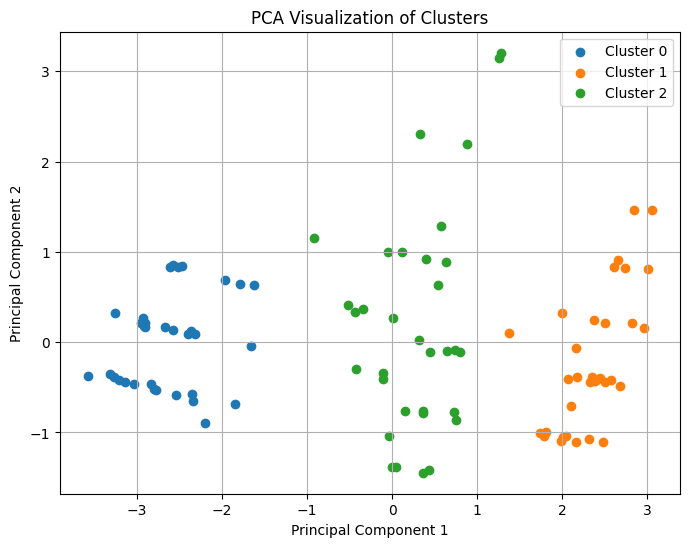

In [38]:
# Visualization with PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Create the PCA model with 2 principal components
pca = PCA(n_components=2)

# Train the model using scaled data
principalComponents = pca.fit_transform(df_scaled)

# Create the dataframe with the results
df_principal = pd.DataFrame(data=principalComponents, columns=['PC 1', 'PC 2'])
df_principal['cluster'] = df['cluster']

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(df_principal[df_principal['cluster'] == 0]['PC 1'], df_principal[df_principal['cluster'] == 0]['PC 2'], label='Cluster 0')
plt.scatter(df_principal[df_principal['cluster'] == 1]['PC 1'], df_principal[df_principal['cluster'] == 1]['PC 2'], label='Cluster 1')
plt.scatter(df_principal[df_principal['cluster'] == 2]['PC 1'], df_principal[df_principal['cluster'] == 2]['PC 2'], label='Cluster 2')

# Customizations
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of Clusters')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

t-SNE
PCA 的替代方案是 t-SNE（t 分布式随机邻域嵌入），它广泛用于自然语言处理。这实际上是相同的压缩概念，因此您可以仅在两个维度上分析数据。

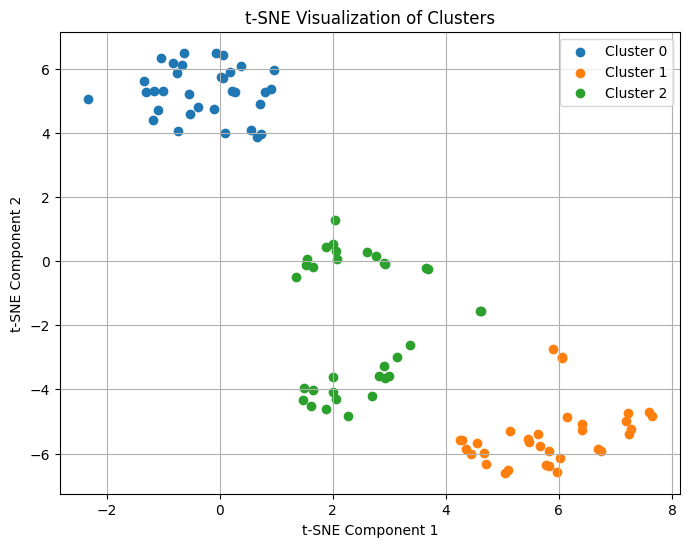

In [39]:
# Visualization with t-SNE (t-distributed Stochastic Neighbor Embedding)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# t-SNE model with 2 components
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_scaled)

# Creating a dataframe for t-SNE results
df_tsne = pd.DataFrame(data=tsne_results, columns=['tsne 1', 'tsne 2'])
df_tsne['cluster'] = df['cluster']

# Plotting the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[df_tsne['cluster'] == 0]['tsne 1'], df_tsne[df_tsne['cluster'] == 0]['tsne 2'], label='Cluster 0')
plt.scatter(df_tsne[df_tsne['cluster'] == 1]['tsne 1'], df_tsne[df_tsne['cluster'] == 1]['tsne 2'], label='Cluster 1')
plt.scatter(df_tsne[df_tsne['cluster'] == 2]['tsne 1'], df_tsne[df_tsne['cluster'] == 2]['tsne 2'], label='Cluster 2')

# Customizations
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Clusters')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

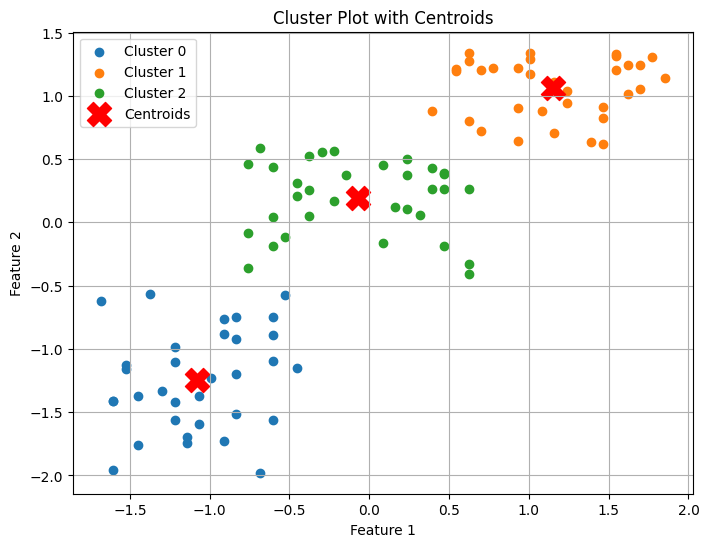

In [40]:
# Create the figure
plt.figure(figsize=(8, 6))

# Loop through clusters
for cluster_num in range(3):
    mask = df['cluster'] == cluster_num
    plt.scatter(df_scaled[mask].iloc[:, 0], df_scaled[mask].iloc[:, 1], label=f'Cluster {cluster_num}')

# Plot the centroids
plt.scatter(model_kmeans.cluster_centers_[:, 0], 
            model_kmeans.cluster_centers_[:, 1], 
            s=300, 
            c='red', 
            marker='X', 
            label='Centroids')

# Customizations
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster Plot with Centroids')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

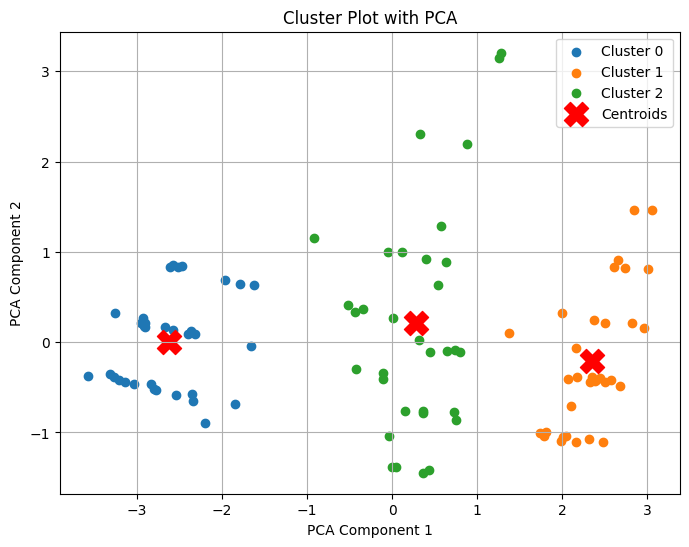

In [41]:
# Import necessary libraries
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Store the PCA results in the dataframe
df['pca_1'] = pca_result[:, 0]
df['pca_2'] = pca_result[:, 1]

# Create the figure
plt.figure(figsize=(8, 6))

# Loop through clusters and plot each one
for cluster_num in range(3):
    mask = df['cluster'] == cluster_num
    plt.scatter(df[mask]['pca_1'], df[mask]['pca_2'], label=f'Cluster {cluster_num}')

# Get the transformed centroids for visualization
centroids_pca = pca.transform(model_kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], 
            centroids_pca[:, 1], 
            s=300, 
            c='red', 
            marker='X', 
            label='Centroids')

# Customizations
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Cluster Plot with PCA')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()